In [1]:
import sys
from pathlib import Path

In [2]:
import numpy as np
import tensorflow as tf

In [3]:
BASE_DIR = Path("..")
sys.path.append(str(BASE_DIR.resolve()))

In [4]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [5]:
from data_pipeline import get_transform_func
from losses import ntxent_loss

# Create Data Processing Pipeline

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [7]:
INPUT_SHAPE = x_train.shape[1:]
NUM_CLASSES = 10
BATCH_SIZE = 128

In [8]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

2022-07-04 00:27:25.792088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 00:27:25.799461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 00:27:25.800051: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 00:27:25.801362: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [9]:
transform_func = get_transform_func(
    NUM_CLASSES, blur = False, crop_resize = True, distort_strength = 0.50,
    crop_size = (0.30, 1.0))

In [10]:
# create train dataset
train_data = train_data.map(
    transform_func, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.cache()
train_data = train_data.shuffle(buffer_size=1024)
train_data = train_data.batch(BATCH_SIZE, drop_remainder = True)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

In [11]:
# create test dataset
test_data = test_data.map(
    transform_func, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.cache()
test_data = test_data.batch(BATCH_SIZE, drop_remainder = True)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

# Create SimClr Network

In [12]:
class AlexNetSimClr(tf.keras.Model):
    def __init__(self,
                 input_shape,
                 num_classes,
                 name = None):
        super(AlexNetSimClr, self).__init__(name = name)
        self._input_shape = input_shape
        self._num_classes = num_classes
        
        # encoder / backbone
        self._conv1 = tf.keras.layers.Conv2D(
            96, 11, 2, 'same', name = 'bbone_conv1')
        self._conv2 = tf.keras.layers.Conv2D(
            256, 5, 1, 'same', name = 'bbone_conv2')
        self._conv3 = tf.keras.layers.Conv2D(
            384, 3, 2, 'same', name = 'bbone_conv3')
        self._conv4 = tf.keras.layers.Conv2D(
            384, 3, 1, 'same', name = 'bbone_conv4')
        self._conv5 = tf.keras.layers.Conv2D(
            356, 3, 1, 'same', name = 'bbone_conv5')        
        self._gpool2d = tf.keras.layers.GlobalAveragePooling2D(name = 'bbone_gpool')
        
        # projection vectors
        self._fc1 = tf.keras.layers.Dense(128, name = 'proj_fc1')
        self._fc2 = tf.keras.layers.Dense(128, name = 'proj_fc2')

    def call(self, x_in):
        # run encoder
        x = self._conv1(x_in)
        x = tf.nn.relu(x, name = 'bbone_relu1')
        x = self._conv2(x)
        x = tf.nn.relu(x, name = 'bbone_relu2')
        x = self._conv3(x)
        x = tf.nn.relu(x, name = 'bbone_relu3')
        x = self._conv4(x)
        x = tf.nn.relu(x, name = 'bbone_relu4')
        x = self._conv5(x)
        x = tf.nn.relu(x, name = 'bbone_relu5')
        x = self._gpool2d(x)
        
        # run projection
        x = self._fc1(x)
        x = tf.nn.relu(x, name = 'relu6')
        x_out = self._fc2(x)

        return x_out
        

In [13]:
simclr = AlexNetSimClr(INPUT_SHAPE, NUM_CLASSES, 'alexnet_simclr')

In [14]:
EPOCHS = 500
DECAY_STEPS = EPOCHS * (len(x_train) // BATCH_SIZE)
LEARNING_RATE = 0.0001

In [15]:
def decayed_learning_rate(step, alpha = 0.0001):
    step = min(step, DECAY_STEPS)
    cosine_decay = 0.5 * (1 + np.cos(np.pi * step / DECAY_STEPS))
    decayed = (1 - alpha) * cosine_decay + alpha
    return LEARNING_RATE * decayed

In [16]:
DECAY_STEPS

195000

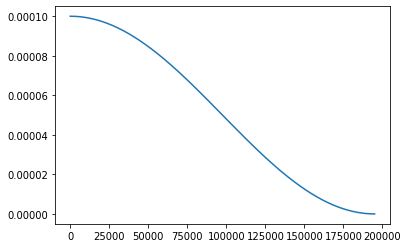

In [17]:
import matplotlib.pyplot as plt
plt.plot([decayed_learning_rate(i) for i in np.arange(DECAY_STEPS)])

In [18]:
lr_decay = tf.keras.optimizers.schedules.CosineDecay(
    LEARNING_RATE, DECAY_STEPS, alpha = 0.0001)
opt=tf.keras.optimizers.Adam(learning_rate = lr_decay)


# Define Training Loop

In [19]:
@tf.function
def train_step(x_batch_a, x_batch_b):
    with tf.GradientTape() as tape:
        proj_a = simclr(x_batch_a)
        proj_b = simclr(x_batch_b)
        loss_value = ntxent_loss(proj_a, proj_b)
    
    opt.minimize(loss_value, simclr.trainable_variables, tape = tape)

    return loss_value


## Train

In [20]:
def train():
    """
        Train EfficientNet SimClr on CIFAR10.
    """

    losses_train = []
    for epoch in range(EPOCHS):
        print(f"Working on epoch: {epoch}...")
        for train_idx, (x_batch_a, x_batch_b, y_batch_train) in enumerate(train_data):
            loss_value_train = train_step(x_batch_a, x_batch_b)
            losses_train.append(loss_value_train.numpy())

            if train_idx % 350 == 0:
                print(f"Loss at step {train_idx} is {loss_value_train.numpy():.2f}.")
    return losses_train


# train and plot loss
train_losses = train()

Working on epoch: 0...


2022-07-04 00:27:31.173321: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204


Loss at step 0 is 4.95.
Loss at step 350 is 4.34.
Working on epoch: 1...
Loss at step 0 is 4.34.
Loss at step 350 is 4.27.
Working on epoch: 2...
Loss at step 0 is 4.29.
Loss at step 350 is 4.26.
Working on epoch: 3...
Loss at step 0 is 4.17.
Loss at step 350 is 4.24.
Working on epoch: 4...
Loss at step 0 is 4.24.
Loss at step 350 is 4.19.
Working on epoch: 5...
Loss at step 0 is 4.20.
Loss at step 350 is 4.20.
Working on epoch: 6...
Loss at step 0 is 4.18.
Loss at step 350 is 4.17.
Working on epoch: 7...
Loss at step 0 is 4.17.
Loss at step 350 is 4.19.
Working on epoch: 8...
Loss at step 0 is 4.13.
Loss at step 350 is 4.14.
Working on epoch: 9...
Loss at step 0 is 4.17.
Loss at step 350 is 4.16.
Working on epoch: 10...
Loss at step 0 is 4.15.
Loss at step 350 is 4.14.
Working on epoch: 11...
Loss at step 0 is 4.10.
Loss at step 350 is 4.17.
Working on epoch: 12...
Loss at step 0 is 4.13.
Loss at step 350 is 4.14.
Working on epoch: 13...
Loss at step 0 is 4.12.
Loss at step 350 is 4.1

# Visualise Loss

In [21]:
import matplotlib.pyplot as plt

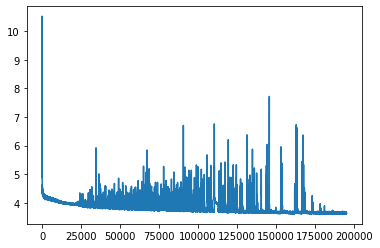

In [22]:
plt.plot(train_losses)

# Save Weights & Model

In [23]:
asset_dir = Path("assets")

In [24]:
weights_path = asset_dir / 'pretrain/weights'
if not weights_path.exists():
    weights_path.mkdir(parents = True, exist_ok = True)

In [25]:
simclr.save_weights(weights_path / f'model_encoder_{EPOCHS}.h5')

In [26]:
model_path = asset_dir / 'pretrain/model'
if not model_path.exists():
    model_path.mkdir(parents = True, exist_ok = True)

In [27]:
simclr.save(model_path / f'model_encoder_{EPOCHS}.tf')

2022-07-04 07:34:35.162302: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: assets/pretrain/model/model_encoder_200.tf/assets
